# Dataset EDA

In [1]:
import json

with open('../data/paper_single_round_1w5_update.json') as file:
    dataset = json.load(file)
    
dataset = [data['conversation'][0] for data in dataset]

In [2]:
print("Total number of papers in the dataset: ", len(dataset))

Total number of papers in the dataset:  15565


Each dataset contains 3 columns: `system`, `input`, and `output`. The instruction contains the system prompt for the model, and the input is the paper content. The output is the summarized reviews of the paper.

In [3]:
dataset[0].keys()

dict_keys(['system', 'input', 'output'])

## Average Number of Words

In [4]:
def average_length(dataset):
    lengths = []
    for data in dataset:
        instruction = data["system"]
        input = data["input"]
        output = data["output"]

        len_instruction = len(instruction.split())
        len_input = len(input.split())
        len_output = len(output.split())

        sum_len = len_instruction + len_input + len_output
        lengths.append(sum_len)

    print("Average number of words in the dataset: ", sum(lengths) / len(lengths))
    return lengths

In [5]:
full_lengths = average_length(dataset)

Average number of words in the dataset:  5679.193639575972


Following the rule of thumb is that one token generally corresponds to ~4 characters of text for common English text. This translates to roughly ¾ of a word (so 100 tokens ~= 75 words). We can use this to estimate the average number of tokens.

In [6]:
token2word_ratio = 4/3
print(
    "Average number of tokens in the dataset: ",
    sum(full_lengths) / len(full_lengths) * token2word_ratio,
)
print("Max number of tokens in the dataset: ", max(full_lengths) * token2word_ratio)

Average number of tokens in the dataset:  7572.258186101296
Max number of tokens in the dataset:  10488.0


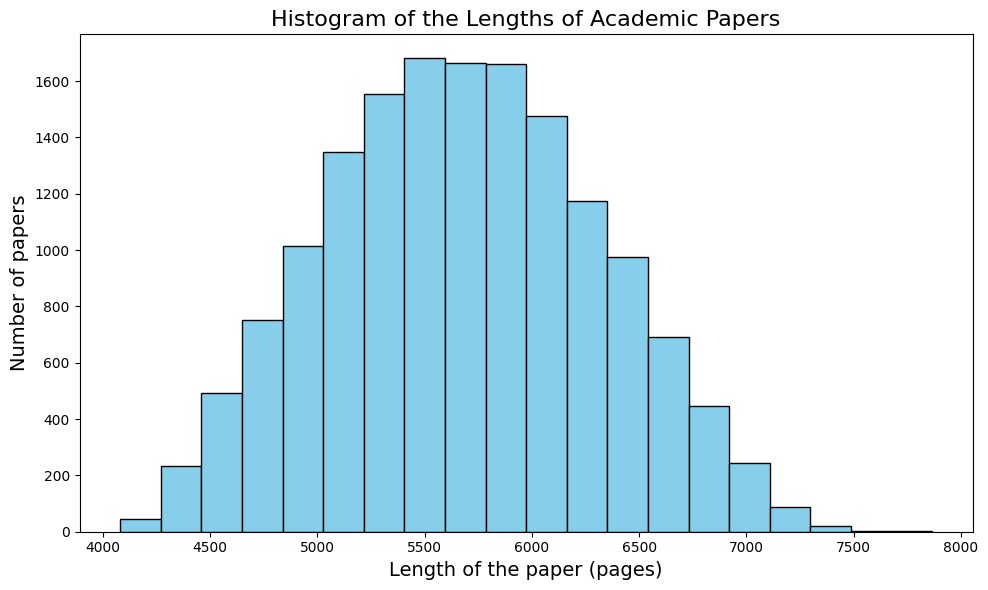

In [7]:
# draw a histogram of the lengths
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(full_lengths, bins=20, color="skyblue", edgecolor="black")
plt.xlabel('Length of the paper (pages)', fontsize=14)
plt.ylabel('Number of papers', fontsize=14)
plt.title('Histogram of the Lengths of Academic Papers', fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.show()

# Abstract Only Dataset

In [8]:
abstract_dataset = [] 

for data in dataset:
    system = data['system']
    input = data['input']
    output = data['output']

    abstract = input.split('[CAPTIONS]')[0].strip()
    
    abstract_dataset.append({
        'system': system,
        'input': abstract,
        'output': output
    })

In [9]:
abstract_dataset[0]

{'system': "You are a professional machine learning conference reviewer who reviews a given paper and considers 4 criteria: [Significance and novelty], [Potential reasons for acceptance], [Potential reasons for rejection], and [Suggestions for improvement]. For each criterion, provide random number of supporting points derived from the paper's content. And for each supporting point, use the format: '<title of supporting point>' followed by a detailed explanation. Your response should only include your reviews only, which means always start with [Significance and novelty], dont' repeat the given paper and output things other than your reviews in required format. The paper is given as follows:",
 'input': "[TITLE]\nImage Quality Assessment Techniques Improve Training and Evaluation of Energy-Based Generative Adversarial Networks\n\n[ABSTRACT]\nWe propose a new, multi-component energy function for energy-based Generative Adversarial Networks (GANs) based on methods from the image quality 

## Average Number of Words

In [10]:
abstract_lengths = average_length(abstract_dataset)

Average number of words in the dataset:  569.3290716350787


In [11]:
token2word_ratio = 4 / 3
print(
    "Average number of tokens in the dataset: ",
    sum(abstract_lengths) / len(abstract_lengths) * token2word_ratio,
)
print("Max number of tokens in the dataset: ", max(abstract_lengths) * token2word_ratio)

Average number of tokens in the dataset:  759.1054288467715
Max number of tokens in the dataset:  1148.0


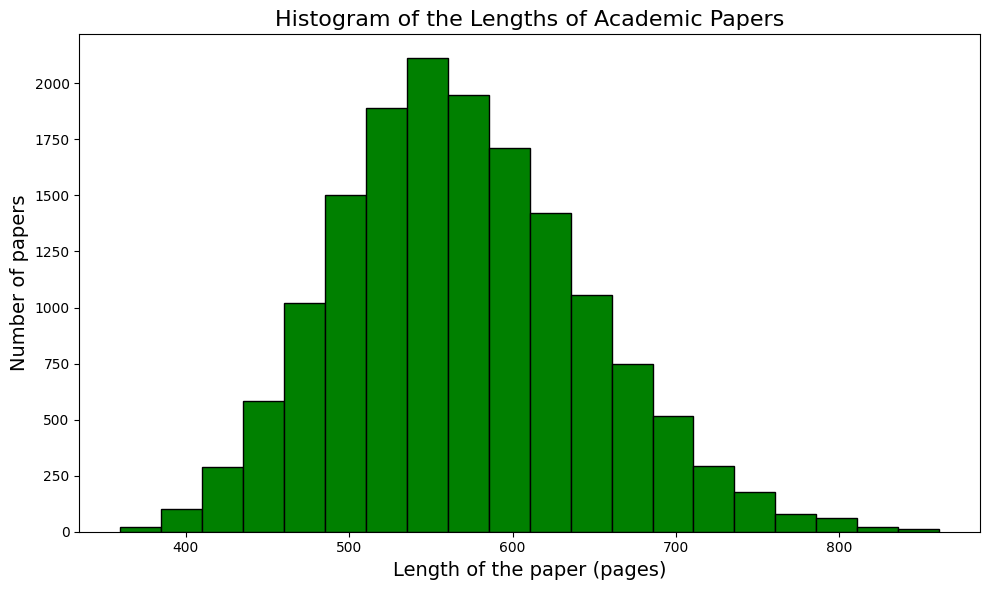

In [12]:
# draw a histogram of the lengths
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(abstract_lengths, bins=20, color="green", edgecolor="black")
plt.xlabel("Length of the paper (pages)", fontsize=14)
plt.ylabel("Number of papers", fontsize=14)
plt.title("Histogram of the Lengths of Academic Papers", fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.show()

# Preprocess Dataset

In [13]:
from datasets import Dataset

random_seed = 42

In [14]:
def create_conversation(sample):
    return {
        "messages": [
            {"role": "system", "content": sample['system']},
            {"role": "user", "content": sample["input"]},
            {"role": "assistant", "content": sample["output"]}
        ]
    }


In [15]:
dataset = Dataset.from_list(dataset)
dataset = dataset.map(create_conversation, remove_columns=dataset.features, batched=False)

Map:   0%|          | 0/15565 [00:00<?, ? examples/s]

In [16]:
print(dataset[0]["messages"])

[{'content': "You are a professional machine learning conference reviewer who reviews a given paper and considers 4 criteria: [Significance and novelty], [Potential reasons for acceptance], [Potential reasons for rejection], and [Suggestions for improvement]. For each criterion, provide random number of supporting points derived from the paper's content. And for each supporting point, use the format: '<title of supporting point>' followed by a detailed explanation. Your response should only include your reviews only, which means always start with [Significance and novelty], dont' repeat the given paper and output things other than your reviews in required format. The paper is given as follows:", 'role': 'system'}, {'content': '[TITLE]\nImage Quality Assessment Techniques Improve Training and Evaluation of Energy-Based Generative Adversarial Networks\n\n[ABSTRACT]\nWe propose a new, multi-component energy function for energy-based Generative Adversarial Networks (GANs) based on methods 

In [17]:
abstract_dataset = Dataset.from_list(abstract_dataset)
abstract_dataset = abstract_dataset.map(create_conversation, remove_columns=abstract_dataset.features, batched=False)

Map:   0%|          | 0/15565 [00:00<?, ? examples/s]

## Split to Train, Validation, and Test

In [18]:
full_dataset = dataset.train_test_split(test_size=0.2, seed=random_seed)

In [19]:
full_dataset

DatasetDict({
    train: Dataset({
        features: ['messages'],
        num_rows: 12452
    })
    test: Dataset({
        features: ['messages'],
        num_rows: 3113
    })
})

In [20]:
abstract_dataset = abstract_dataset.train_test_split(test_size=0.2, seed=random_seed)
abstract_dataset

DatasetDict({
    train: Dataset({
        features: ['messages'],
        num_rows: 12452
    })
    test: Dataset({
        features: ['messages'],
        num_rows: 3113
    })
})

In [21]:
# save the full dataset
full_dataset['train'].to_json('../data/full_dataset/train.json', orient='records')
full_dataset["test"].to_json("../data/full_dataset/test.json", orient="records")
abstract_dataset["train"].to_json(
    "../data/abstract_dataset/train.json", orient="records"
)
abstract_dataset["test"].to_json("../data/abstract_dataset/test.json", orient="records")

Creating json from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

13282827